# Access tri-seasonal Sentinel-1 SAR composites
Paul Montesano  
Oct 2023  
NASA Goddard Space Flight Center  
Multi-Mission Algorithm and Analysis Platform (MAAP) | https://www.earthdata.nasa.gov/esds/maap
#### An example of running a script to transfer a Google Earth Engine asset to a local dir

In [52]:
import ee
import os, sys
# Add the subdir where the script is located to your PATH variable.
sys.path.append('/projects/code/icesat2_boreal/lib')
import do_gee_download_by_subtile
import rasterio
from rasterio.plot import show_hist, show
import numpy as np
import matplotlib.pyplot as plt
import shapely
import geopandas as gpd
import glob

### Run
Transfer an arbitrary subtile (500m x 500m) of a ***tri-seasonal composite*** of `gamma-nought` (RTC) `Sentinel 1` SAR scenes from 2018  

Seasonal grouping of scenes:
 - frozen (Jan-March)  
 - summer (June-August)  
 - shoulder (Sept-Oct)

In [12]:
do_gee_download_by_subtile.do_gee_download_by_subtile(SUBTILE_LOC=2000, 
                                                      ID_NUM=50, 
                                                      ID_COL='AGG_TILE_NUM', 
                                                      ASSET_PATH='projects/foreststructure/Circumboreal/S1_Composites_albers', 
                                                      TILE_SIZE_M=500, 
                                                      OUTDIR='/projects/my-public-bucket/do_gee_download_by_subtile_TEST'
                                                     )


	Subtile 2000 for AGG_TILE_NUM # 50 (s1_vv_vh_gamma_2018_pwr_tile50) to subdir: /projects/my-public-bucket/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile50
	SUBTILE_LOC: 2000 : extracted tifs to /projects/my-public-bucket/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile50-subtile002000


[]

### Collect output files

In [15]:
fn_list = glob.glob('/projects/my-public-bucket/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile50-subtile002000/*.tif')
fn_list

['/projects/my-public-bucket/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile50-subtile002000/s1_vv_vh_gamma_2018_pwr_tile50.VH_median_frozen-subtile002000.tif',
 '/projects/my-public-bucket/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile50-subtile002000/s1_vv_vh_gamma_2018_pwr_tile50.VH_median_shoulder-subtile002000.tif',
 '/projects/my-public-bucket/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile50-subtile002000/s1_vv_vh_gamma_2018_pwr_tile50.VH_median_summer-subtile002000.tif',
 '/projects/my-public-bucket/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile50-subtile002000/s1_vv_vh_gamma_2018_pwr_tile50.VV_median_frozen-subtile002000.tif',
 '/projects/my-public-bucket/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile50-subtile002000/s1_vv_vh_gamma_2018_pwr_tile50.VV_median_shoulder-subtile002000.tif',
 '/projects/my-public-bucket/do_gee_download_by_subtile_TEST/s1_vv_vh_gamma_2018_pwr_tile50-subtile002000/s1_vv_vh_gamma_2018_

### Plot a multiband composite

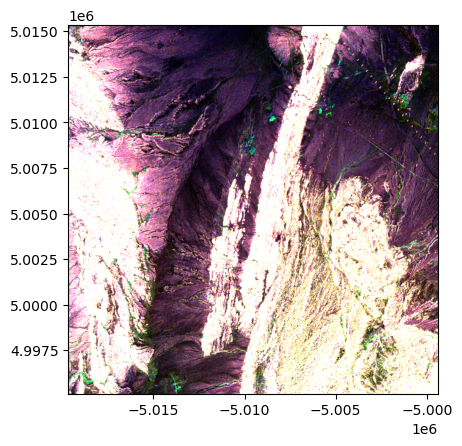

In [63]:
outdir = os.path.dirname(fn_list[2])
multiband_fn = os.path.join(outdir, 'multi_band_temp.tif')

def pct_clip(array, pct=[1,80]):
    array_min, array_max = np.nanpercentile(array,pct[0]), np.nanpercentile(array,pct[1])
    clip = (array - array_min) / (array_max - array_min)
    clip[clip>1]=1
    clip[clip<0]=0
    return clip

with rasterio.open(fn_list[0]) as src1:
    with rasterio.open(fn_list[2]) as src2:
        with rasterio.open(fn_list[5]) as src3:
            
            arr1 = src1.read(1)
            arr2 = src2.read(1)
            arr3 = src3.read(1)
            with rasterio.open(multiband_fn, 'w+',
                    driver='GTiff',
                    dtype= rasterio.float32,
                    count=3,
                    crs = src1.crs,
                    width=src1.width,
                    height=src1.height,
                    transform=src1.transform,
                ) as dst:
                V = pct_clip(src1.read(1), pct=[1,60])
                dst.write(V,1)
                V = pct_clip(src2.read(1), pct=[1,70])
                dst.write(V,2)
                V = pct_clip(src3.read(1), pct=[1,75])
                dst.write(V,3)
                
fig,ax=plt.subplots()
with rasterio.open(multiband_fn) as src:
    show(src.read(),transform=src.transform,ax=ax)
    bounds  = src.bounds

In [64]:
gdf = gpd.GeoDataFrame({"id":1,"geometry":[shapely.geometry.box(*bounds)]}, crs=src.crs)
gdf.to_crs(4326).explore(height=300, width = 500)